# Testing the Convex Networking Model

This notebook demonstrates how to load the `InConvexHull` custom layer, generate synthetic test data in arbitrary dimensions with a fuzzy boundary, visualize 3D data, build and train a simple model, visualize the learned hull (in 3D), and make predictions.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import the custom layer from the convexNetworking.py file
try:
    from convexNetworking import InConvexHull
except ImportError:
    # If the file is not directly in the path, you might need to adjust the import
    # For example, if it's in a subdirectory named 'convexNetworking'
    import sys
    import os
    # Assuming convexNetworking.py is in the parent directory of this notebook
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
    from convexNetworking import InConvexHull

print("TensorFlow version:", tf.__version__)
print("Custom layer 'InConvexHull' imported successfully.")

TensorFlow version: 2.12.0
Custom layer 'InConvexHull' imported successfully.


## Generate Test Data with Fuzzy Boundary

We will generate data points and label them probabilistically based on their L1 norm, creating a fuzzy boundary around the L1 unit ball.

Adjust `n_dim` for dimensions and `fuzziness_scale` for the boundary sharpness (lower means fuzzier).

The `l1_norm_threshold` is adjusted based on the dimension to center the fuzzy region within the distribution of L1 norms.

In [2]:
size = 2000 # Number of samples
n_dim = 3 # Number of dimensions (change this for high-dimensional testing)
data_range = 1.5 # Range of point generation [-data_range, data_range]

# Adjust the L1 norm threshold based on the number of dimensions and data range
# A threshold that scales with n_dim is needed for high dimensions.
# This heuristic sets the threshold to the expected L1 norm for uniform distribution in [-data_range, data_range]
l1_norm_threshold = n_dim * data_range * 0.5 
# You can also experiment with this factor (0.5) or set a fixed threshold if you prefer.

fuzziness_scale = 5.0 # Lower values mean a fuzzier boundary (experiment with this parameter)

np.random.seed(42)

# Generate points in the range [-data_range, data_range] for each dimension
xs = (2 * np.random.rand(size, n_dim) - 1) * data_range
column_names = [f"dim_{i+1}" for i in range(n_dim)]
df = pd.DataFrame(xs, columns=column_names)

# Calculate L1 norm for each point
l1_norms = np.sum(np.abs(xs), axis=1)

# Print statistics of L1 norms to understand their distribution
print(f"L1 Norm Statistics (n_dim={n_dim}):")
print(f"  Mean: {np.mean(l1_norms):.4f}")
print(f"  Standard Deviation: {np.std(l1_norms):.4f}")
print(f"  Min: {np.min(l1_norms):.4f}")
print(f"  Max: {np.max(l1_norms):.4f}")
print(f"Calculated L1 norm threshold: {l1_norm_threshold:.4f}")

# Use a sigmoid function to get the probability of being 'outside' (label 0)
# The sigmoid will be centered around l1_norm_threshold
prob_outside = 1 / (1 + np.exp(-fuzziness_scale * (l1_norms - l1_norm_threshold)))

# Generate labels based on the probabilities
# Label 1 (inside) with probability 1 - prob_outside
# Label 0 (outside) with probability prob_outside
ys = (np.random.rand(size) < (1 - prob_outside)).astype(int).reshape(-1, 1)

# Shuffle data (already somewhat shuffled by random generation, but good practice)
indices = np.arange(xs.shape[0])
np.random.shuffle(indices)
xs = xs[indices]
ys = ys[indices]

print(f"Generated {len(xs)} samples with {n_dim} dimensions and a fuzzy boundary.")
print(f"{np.sum(ys)} points labeled as inside (1).")
print(f"{len(xs) - np.sum(ys)} points labeled as outside (0).")

L1 Norm Statistics (n_dim=3):
  Mean: 2.2600
  Standard Deviation: 0.7394
  Min: 0.2505
  Max: 4.3132
Calculated L1 norm threshold: 2.2500
Generated 2000 samples with 3 dimensions and a fuzzy boundary.
993 points labeled as inside (1).
1007 points labeled as outside (0).


## Visualize Test Data (3D only)

Visualize the generated data points if the dimension is 3.

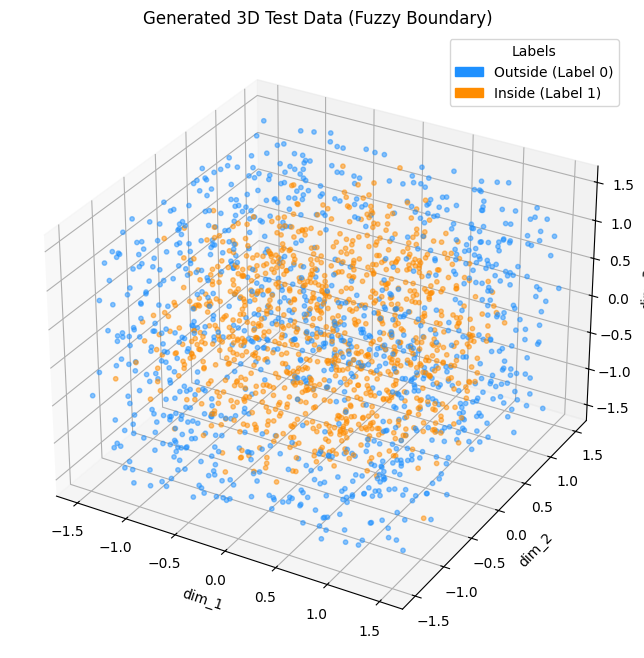

In [3]:
if n_dim == 3:
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111, projection='3d')

    # Separate points by their label (1 for inside, 0 for outside)
    df_viz = pd.DataFrame(xs, columns=[f'dim_{i+1}' for i in range(n_dim)])
    df_viz['label'] = ys

    # For fuzzy data, visualizing color transitions might be more informative
    # Plotting all points and coloring by label probability or just the assigned label

    # Option 1: Color by assigned label (shows the fuzzy boundary visually)
    colors = ['dodgerblue' if label == 0 else 'darkorange' for label in df_viz['label']]
    scatter = ax.scatter(df_viz.iloc[:,0], df_viz.iloc[:,1], df_viz.iloc[:,2], c=colors, s=10, alpha=0.5)

    # Create a legend manually since colors are assigned per point
    import matplotlib.patches as mpatches
    labels = ['Outside (Label 0)', 'Inside (Label 1)']
    handles = [mpatches.Patch(color='dodgerblue', label='Outside (Label 0)'),
               mpatches.Patch(color='darkorange', label='Inside (Label 1)')]
    ax.legend(handles=handles, title='Labels')

    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])
    plt.title('Generated 3D Test Data (Fuzzy Boundary)')
    plt.show()
else:
    print(f"Data dimension ({n_dim}) is not 3. Skipping 3D data visualization.")

## Build and Compile the Model

We will create a simple Sequential model with the `InConvexHull` layer. The number of hyperplanes is set to twice the number of dimensions, which is sufficient to define a cross-polytope. You can experiment with fewer hyperplanes as well.

In [4]:
# Define the model using the custom layer
# For an N-dimensional cross-polytope (L1 ball), 2*N hyperplanes are sufficient.
# You can try n_dim + 1 here as well to compare.
num_hyperplanes_to_learn = 2 * n_dim 
# num_hyperplanes_to_learn = n_dim + 1

model = keras.Sequential([
    # Input layer - specify input shape
    keras.layers.InputLayer(input_shape=(n_dim,)),
    # Add the custom convex hull layer
    InConvexHull(num_hyperplanes=num_hyperplanes_to_learn),
    # The custom layer outputs a score between 0 and 1, suitable for binary classification
])

# Compile the model
# Use BinaryCrossentropy as the loss function since the output is a score/probability for binary classification
model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in_convex_hull (InConvexHul  (None, 1)                24        
 l)                                                              
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


## Train the Model

Train the model using the generated data.

In [5]:
print("\nTraining the model...")
# You might need to adjust the number of epochs based on your data and desired accuracy
# With a fuzzy boundary, perfect accuracy is unlikely. The validation split helps monitor for overfitting.
history = model.fit(xs, ys, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Training the model...
Epoch 1/50
50/50 [==============================] - 0s 4ms/step - loss: 1.8671 - accuracy: 0.4981 - val_loss: 0.8725 - val_accuracy: 0.4825
Epoch 2/50
50/50 [==============================] - 0s 1ms/step - loss: 0.6136 - accuracy: 0.6675 - val_loss: 0.6089 - val_accuracy: 0.6775
Epoch 3/50
50/50 [==============================] - 0s 1ms/step - loss: 0.5464 - accuracy: 0.7819 - val_loss: 0.5739 - val_accuracy: 0.7300
Epoch 4/50
50/50 [==============================] - 0s 1ms/step - loss: 0.5121 - accuracy: 0.7994 - val_loss: 0.5475 - val_accuracy: 0.7300
Epoch 5/50
50/50 [==============================] - 0s 1ms/step - loss: 0.4850 - accuracy: 0.8100 - val_loss: 0.5218 - val_accuracy: 0.7275
Epoch 6/50
50/50 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 0.8156 - val_loss: 0.5090 - val_accuracy: 0.7525
Epoch 7/50
50/50 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.8225 - val_loss: 0.5005 - val_accuracy: 0.73

## Evaluate the Model (Optional)

Evaluate the trained model on the entire dataset.

In [6]:
# Evaluate the model on the training data
# With a fuzzy boundary, the loss and accuracy will reflect the probabilistic nature of the labels.
loss, accuracy = model.evaluate(xs, ys, verbose=0)
print(f"\nOverall Loss: {loss:.4f}, Overall Accuracy: {accuracy:.4f}")


Overall Loss: 0.3522, Overall Accuracy: 0.8350


## Visualize Learned Hull and Test Points (3D only)

Access the learned hyperplane parameters and visualize the learned planes along with a subset of the data points if the dimension is 3.


Visualizing learned hyperplanes and data points...


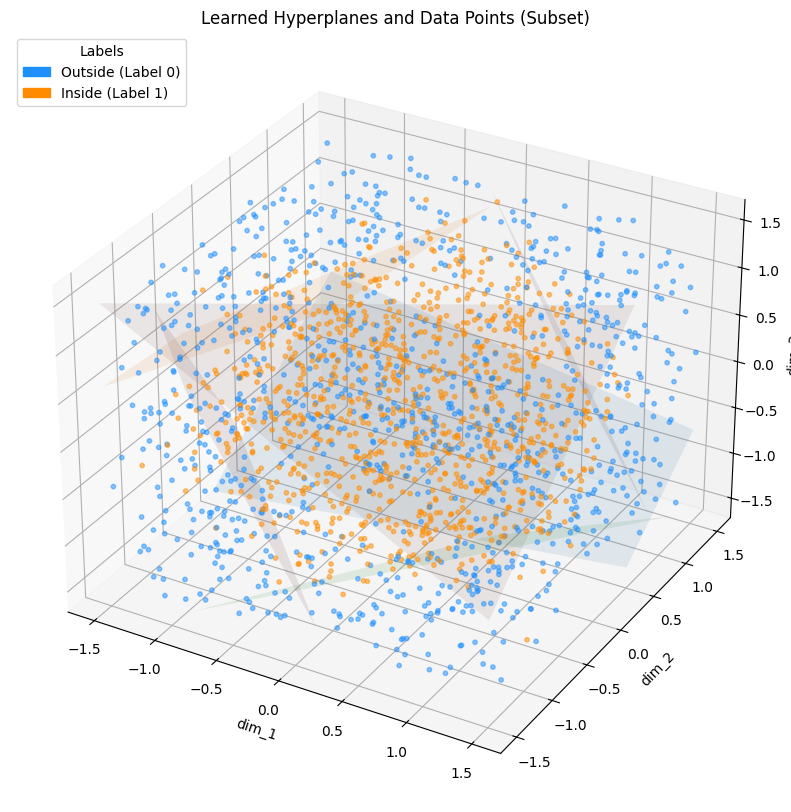

In [7]:
if n_dim == 3:
    print("\nVisualizing learned hyperplanes and data points...")

    # Get the learned weights (normal vectors) and biases from the InConvexHull layer
    learned_normal_vectors = model.layers[0].get_weights()[0]
    learned_biases = model.layers[0].get_weights()[1]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot a subset of the data points for clarity
    subset_indices = np.random.choice(len(xs), size=min(len(xs), 5000), replace=False)
    xs_subset = xs[subset_indices]
    ys_subset = ys[subset_indices]

    df_viz_subset = pd.DataFrame(xs_subset, columns=[f'dim_{i+1}' for i in range(n_dim)])
    df_viz_subset['label'] = ys_subset

    colors_subset = ['dodgerblue' if label == 0 else 'darkorange' for label in df_viz_subset['label']]
    ax.scatter(df_viz_subset.iloc[:,0], df_viz_subset.iloc[:,1], df_viz_subset.iloc[:,2], c=colors_subset, s=10, alpha=0.5)

    # Create a legend for the data points
    import matplotlib.patches as mpatches
    labels = ['Outside (Label 0)', 'Inside (Label 1)']
    handles = [mpatches.Patch(color='dodgerblue', label='Outside (Label 0)'),
               mpatches.Patch(color='darkorange', label='Inside (Label 1)')]
    ax.legend(handles=handles, title='Labels', loc='upper left')


    # Define plotting ranges for the planes (adjust as needed based on your data distribution)
    # Use the full range of the generated data for plane visualization
    range_limit = data_range # Defined in data generation cell
    x_range = np.linspace(-range_limit, range_limit, 10)
    y_range = np.linspace(-range_limit, range_limit, 10)
    X_plane, Y_plane = np.meshgrid(x_range, y_range)

    # Plot each learned hyperplane
    for i in range(len(learned_normal_vectors)):
        w = learned_normal_vectors[i]
        b = learned_biases[i]

        # The plane equation is w[0]*x + w[1]*y + w[2]*z + b = 0
        # Solve for z: z = -(w[0]*x + w[1]*y + b) / w[2]
        # Handle the case where w[2] is close to zero (vertical plane)
        if np.abs(w[2]) > 1e-9:
            Z_plane = -(w[0] * X_plane + w[1] * Y_plane + b) / w[2]
            # Mask values outside a reasonable range to avoid plotting distant parts of the plane
            Z_plane[(Z_plane < -range_limit) | (Z_plane > range_limit)] = np.nan
            ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.1, rstride=100, cstride=100, color=f'C{i%10}')
        # More complex cases for vertical or near-vertical planes are not plotted for simplicity
        elif np.abs(w[0]) > 1e-9 or np.abs(w[1]) > 1e-9:
             print(f"Skipping plot for vertical or near-vertical plane {i+1}.")
        else:
             print(f"Skipping plot for degenerate plane {i+1}.")

    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])
    ax.set_title('Learned Hyperplanes and Data Points (Subset)')
    
    # Set equal aspect ratio - might distort appearance but shows true shape
    # ax.set_box_aspect([1,1,1]) 

    plt.show()
else:
    print(f"Data dimension ({n_dim}) is not 3. Skipping learned hull visualization.")

## Make Predictions

Use the trained model to predict the 'hull score' for new data points. A score closer to 1 indicates that the point is likely inside the learned convex hull.

In [ ]:
# Create some new test points (ensure they have the same dimension as the training data)
# Example test points for n_dim = 3:
if n_dim == 3:
    test_points = np.array([
        [0.0, 0.0, 0.0], # Should be Inside (L1 norm = 0)
        [0.1, 0.1, 0.1], # Should be Inside (L1 norm = 0.3)
        [0.3, 0.3, 0.3], # Should be near boundary (L1 norm = 0.9)
        [0.5, 0.5, 0.5], # Should be Outside (L1 norm = 1.5)
        [-0.2, 0.2, -0.2], # Should be Inside (L1 norm = 0.6)
        [1.0, 0.0, 0.0], # Should be near boundary (L1 norm = 1.0)
        [1.1, 0.0, 0.0], # Should be Outside (L1 norm = 1.1)
        [10.0, 10.0, 10.0] # Should be Far Outside (L1 norm = 30)
    ], dtype=np.float32)

    # Predict the hull scores
    predictions = model.predict(test_points)

    print("\nHull scores for test points (3D example):")
    for i, point in enumerate(test_points):
        # For fuzzy data, the score is a better indicator than a hard threshold
        print(f"Point: {point}, Hull Score: {predictions[i][0]:.4f}")

    # can still use a threshold for classification, but the interpretation is less strict with fuzzy data
    threshold = 0.5
    print(f"\nClassification based on threshold > {threshold} (3D example):")
    for i, point in enumerate(test_points):
        is_inside_predicted = predictions[i][0] > threshold
        # For reference, let's also see the original 'fuzzy' label probability and the sampled label for these points
        l1_norm_point = np.sum(np.abs(point))
        prob_outside_point = 1 / (1 + np.exp(-fuzziness_scale * (l1_norm_point - l1_norm_threshold)))
        prob_inside_point = 1 - prob_outside_point
        print(f"Point: {point}, Predicted Inside (>{threshold}): {is_inside_predicted}, Original Prob Inside: {prob_inside_point:.4f}")

else:
    print(f"Data dimension ({n_dim}) is not 3. Skipping 3D test points prediction example.")
    # You can create test points for the higher dimension manually here if needed.
    # Example for a higher dimension (replace N with your chosen n_dim):
    # high_dim_test_points = np.random.rand(10, n_dim).astype(np.float32)
    # high_dim_predictions = model.predict(high_dim_test_points)
    # print(f"\nHull scores for {n_dim}D test points:")
    # print(high_dim_predictions)

1/1 [==============================] - 0s 54ms/step

Hull scores for test points (3D example):
Point: [0. 0. 0.], Hull Score: 0.9981
Point: [0.1 0.1 0.1], Hull Score: 0.9981
Point: [0.3 0.3 0.3], Hull Score: 0.9938
Point: [0.5 0.5 0.5], Hull Score: 0.9475
Point: [-0.2  0.2 -0.2], Hull Score: 0.9968
Point: [1. 0. 0.], Hull Score: 0.9645
Point: [1.1 0.  0. ], Hull Score: 0.9442
Point: [10. 10. 10.], Hull Score: 0.0000

Classification based on threshold > 0.5 (3D example):
Point: [0. 0. 0.], Predicted Inside (>0.5): True, Original Prob Inside: 1.0000
Point: [0.1 0.1 0.1], Predicted Inside (>0.5): True, Original Prob Inside: 0.9999
Point: [0.3 0.3 0.3], Predicted Inside (>0.5): True, Original Prob Inside: 0.9988
Point: [0.5 0.5 0.5], Predicted Inside (>0.5): True, Original Prob Inside: 0.9770
Point: [-0.2  0.2 -0.2], Predicted Inside (>0.5): True, Original Prob Inside: 0.9997
Point: [1. 0. 0.], Predicted Inside (>0.5): True, Original Prob Inside: 0.9981
Point: [1.1 0.  0. ], Predicted Insi